<a href="https://colab.research.google.com/github/samuelecivale/Lab-Iagi/blob/main/Esercitazione_7_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /Users/samuelecivale/Desktop/università
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.2861,), std=(0.353,))
           )
12000
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /Users/samuelecivale/Desktop/universita
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.2861,), std=(0.353,))
           )
Train Epoch: 1 [0/48000 (0%)]	Loss: 2.285070
Train Epoch: 1 [12800/48000 (27%)]	Loss: 1.893636
Train Epoch: 1 [25600/48000 (53%)]	Loss: 1.151951
Train Epoch: 1 [38400/48000 (80%)]	Loss: 1.126649

Validation set: Average loss: 0.2711, Accuracy: 8747/12000 (72.89%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 0.841411
Train Epoch: 2 [12800/48000 (27%)]	Loss: 0.590250
Train Epoch: 2 [25600/48000 (53%)]	Loss: 0.917578
Train Epoch: 2 [38400/48000 (80%)]	Loss: 0.653258

Val

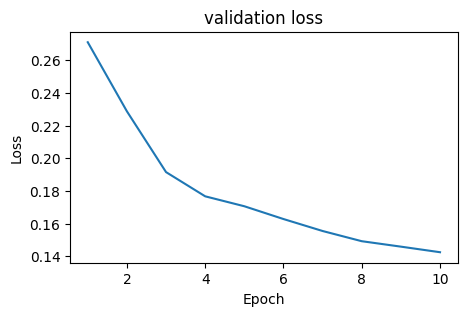

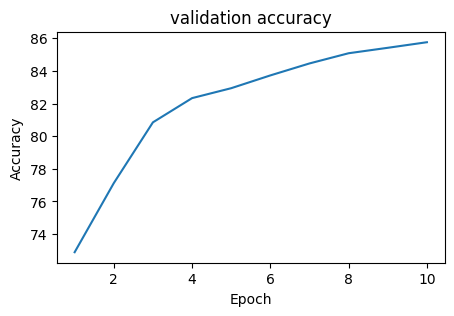

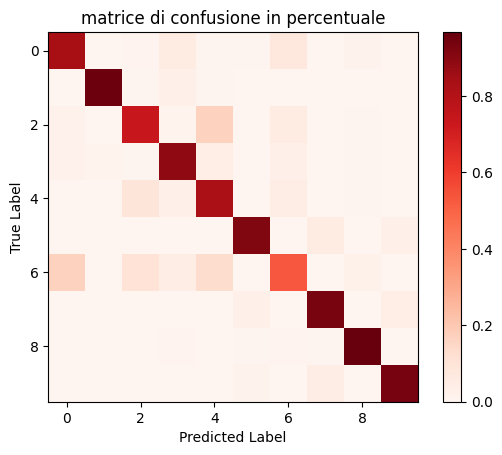

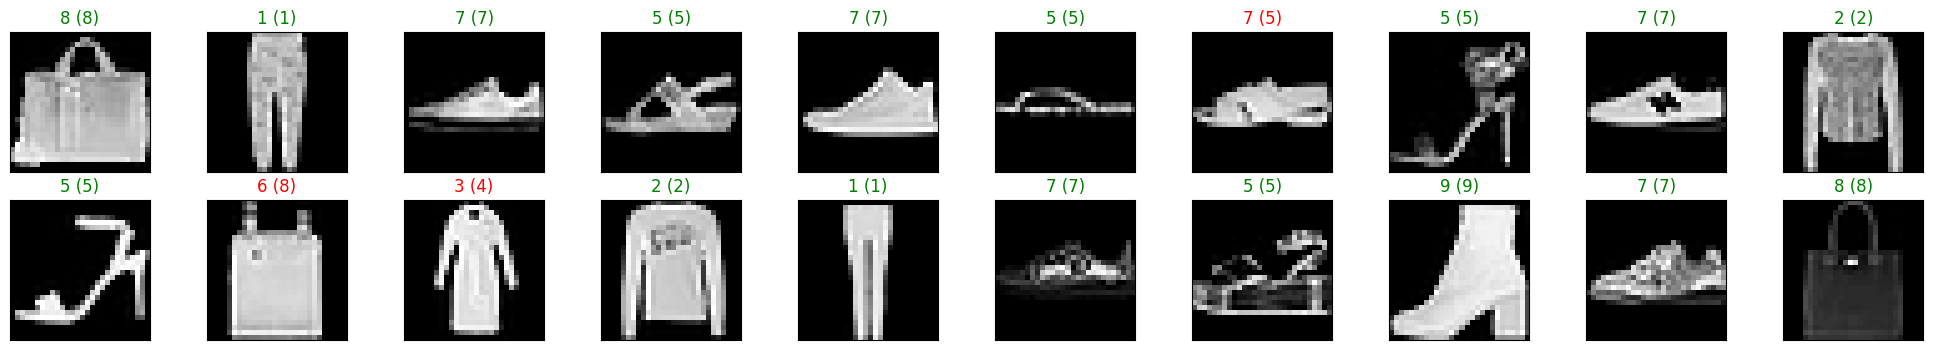

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Define a transform to normalize the data
# HINT: you have to transform the images to tensors and then normalize them to have zero mean
"""
 trasformazione da applicare alle immagini del dataset FashionMNIST
 I valori specificati (0.2861,) e (0.3530,) rappresentano la media e la deviazione standard delle intensità dei pixel nel dataset FashionMNIST.
"""
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2861,), (0.3530,))
])

# Download the training data
trainset = datasets.FashionMNIST(root='/Users/samuelecivale/Desktop/università', train=True, download=True, transform=transform)
print(trainset)

"""
crea un set di dati di addestramento e un set di dati di validazione separando il set di addestramento in base a una proporzione del 20%.
data loader: struttura ceh aiuta nel caricamento dei dati e nella gestione dei mini batch, shuffling e parallelismo (uso GPU) se richiesto
"""

#We prepare 20% of the train set as a validation set
indices = list(range(len(trainset)))
np.random.shuffle(indices)
split = int(np.floor(0.2*len(trainset)))
print(split)
valid_sample = SubsetRandomSampler(indices[:split])
train_sample = SubsetRandomSampler(indices[split:])

#Load the training and validation data
train_loader = DataLoader(trainset, sampler=train_sample, batch_size=64)
valid_loader = DataLoader(trainset, sampler=valid_sample, batch_size=64)

# Download and load the test data
testset = datasets.FashionMNIST(root='/Users/samuelecivale/Desktop/universita', train=False, download=True, transform=transform)

test_loader = DataLoader(testset, batch_size=64, shuffle=True)
print(testset)


"""
Creiamo il modello,
input: 784, 28x28 img
layer: 3, (256,128,64)
output: 10 (le 10 classi di smistamento oggetti)
funzione di attivazione: ReLU ( Rectified Linear Unit: f(x) = max(0,x). Una funzione di attivazione in una rete neurale è
                                responsabile di introdurre non-linearità nel modello. La sua funzione principale è quella di determinare
                                l'output di un nodo o di un insieme di nodi in base all'input ricevuto.)

dropout 20% (Durante la fase di addestramento, lo strato di dropout "spegne" casualmente il 20% degli elementi dell'input, fornendo
             un meccanismo di regolarizzazione che aiuta a prevenire l'overfitting.)

Il metodo forward genera un tensore delle probabilità logaritmiche associato a ciascuna classe per ogni campione nel tuo batch.
Queste probabilità logaritmiche sono ottenute applicando la funzione log-softmax all'output finale della tua rete neurale.
"""

#Now we create the model
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        #We will have input(784), 3 hidden layers(256,128,64) and output(10)
        #Could have built a stack with nn.Sequential. May do so later to simplify the forward function
        self.linear1 = nn.Linear(784, 256)
        self.act_f1 = nn.ReLU()

        self.linear2 = nn.Linear(256, 128)
        self.act_f2 = nn.ReLU()

        self.linear3 = nn.Linear(128, 64)
        self.act_f3 = nn.ReLU()

        self.linear4 = nn.Linear(64, 10)

        #We define a 20% dropout. During training this will randomly zero some elements of the input tensor, which has proven to be an effective technique for regularization
        self.dropout = nn.Dropout(0.2)

    #Now we define the forward function for our network
    """

    Il metodo forward genera un tensore delle probabilità logaritmiche associato a ciascuna classe per ogni campione nel tuo batch.
    Queste probabilità logaritmiche sono ottenute applicando la funzione log-softmax all'output finale della tua rete neurale.
    definisce come l'input si muove in avanti nella rete:

    x = self.linear1(x): Passa l'input attraverso il primo strato lineare (self.linear1). Questo strato applica una trasformazione lineare agli input,
                        che è rappresentata dalla moltiplicazione per la matrice di pesi e l'aggiunta di un vettore di bias.
    x = self.act_f1(x): Applica la funzione di attivazione ReLU al risultato del primo strato lineare. Questa introduce non-linearità nel modello.
    x = self.dropout(x): Applica il layer di dropout al risultato del primo strato attivato da ReLU. Il dropout "spegne" casualmente alcuni neuroni durante
                         l'addestramento per prevenire l'overfitting.
    .
    .
    .

    x = self.linear4(x): Passa l'output del terzo strato attraverso l'ultimo strato lineare (self.linear4), che produce l'output finale della rete.
    return F.log_softmax(x, dim=1): Applica la funzione log-softmax all'output finale. La log-softmax è spesso utilizzata come funzione di attivazione
                                    per problemi di classificazione multiclasse, convertendo gli output in probabilità logaritmiche.
    """
    def forward(self,x):
       #appiattisce l'input x, che è una immagine rappresentata come un tensore tridimensionale, in un vettore unidimensionale.
        x = x.view(x.shape[0], -1)

        x = self.linear1(x)
        x = self.act_f1(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.act_f2(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.act_f3(x)
        x = self.dropout(x)

        x = self.linear4(x)

        return F.log_softmax(x, dim=1)


"""
viene utilizzata la Negative Log Likelihood Loss (NLLLoss). Questa loss function è comunemente utilizzata per problemi di classificazione multiclasse,
in particolare quando la funzione di attivazione dell'ultimo strato è la log-

L'obiettivo principale di SGD è minimizzare la funzione di loss regolando i parametri del modello.
La versione "stocastica" di SGD indica che l'aggiornamento dei parametri viene eseguito su un singolo esempio (o su un piccolo gruppo di esempi, chiamato batch) in modo casuale.


"""

model = Classifier()

#We define the loss function (Negative Log Likelihood Loss) and the optimizer (Stochastic Gradient Descent)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
"""
funzione d'addestramento della nostra rete neruale:
cicla su ogni batch e su ogni (immagine, etichetta) nel train loader:
          Azzera i gradienti dei parametri del modello. È necessario farlo prima di ogni iterazione per evitare che i gradienti si accumulino.
          Esegue il passaggio di inoltro attraverso il modello per ottenere le previsioni per il batch corrente.
          Spreme le dimensioni superflue (nel caso in cui il modello restituisca un tensore con dimensioni [batch_size, 1]) per ottenere un tensore di dimensioni [batch_size].
          Calcola la loss confrontando le previsioni del modello (preds) con le etichette reali (labels).
          Esegue la retropropagazione del gradiente, calcolando i gradienti rispetto ai parametri del modello. (se ne occupa PyThorch)
          L'SGD esegue un passo avanti nell'ottimizzazione dei parametri
          Stampa info sull'andamento dell'addestramento
"""
#We define the training function
def train(epoch, log_interval=200):
    model.train()

    for batch_idx, (images, labels) in enumerate(train_loader):

        optimizer.zero_grad()

        preds = model(images)
        preds = preds.squeeze(dim=1)

        loss = criterion(preds, labels)
        loss.backward()

        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.sampler),
                100. * batch_idx / len(train_loader), loss.data.item()))


#We define the validation function

def validate(loss_vector, accuracy_vector):

    model.eval()
    correct_count, all_count = 0, 0
    loss_count = 0

    for images,labels in valid_loader:
      for i in range(len(labels)):
        img = images[i].view(1, 784) # Itera attraverso i singoli esempi nel batch corrente:
        with torch.no_grad():  #Impedisce il calcolo e l'accumulo dei gradienti durante la valutazione per risparmiare risorse computazionali.

            pred = model(img) # Ottiene le previsioni del modello per l'immagine corrente.

        ps = torch.exp(pred) #Applica la funzione di espansione (esponenziale, perchè il risultato della forward è un logaritmo delle probabilità) alle previsioni per ottenere le probabilità.
        probab = list(ps[0]) # Converte il tensore delle probabilità in una lista.
        pred_label = probab.index(max(probab))  #Determina la classe predetta cercando l'indice dell'elemento con la probabilità massima.
        true_label = labels[i]
        if(true_label == pred_label):
          correct_count += 1
        else:
          loss_count += 1

        all_count += 1

    avg_loss = loss_count/all_count #calcola la loss media
    accuracy = correct_count/all_count * 100

    loss_vector.append(avg_loss)
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        avg_loss, correct_count, all_count, accuracy))

"""
Vengono eseguite 10 epoche di addestramento.
Per ogni epoca, la funzione train viene chiamata per addestrare il modello sul set di addestramento.
Successivamente, la funzione validate viene chiamata per valutare le prestazioni del modello sul set di validazione. Le loss e l'accuratezza vengono registrate in lossv e accv.
"""
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

# Viene creato un grafico che mostra come varia la loss di validazione nel corso delle epoche.
plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, epochs + 1), lossv)
plt.title('validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Viene creato un grafico che mostra come varia l'accuratezza di validazione nel corso delle epoche.
plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, epochs + 1), accv)
plt.title('validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        output = model(images)
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)
class_percentages = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.imshow(class_percentages, cmap='Reds', interpolation='nearest')
plt.title('matrice di confusione in percentuale')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



"""
Viene ottenuto un batch di immagini dal set di test.
Il modello viene utilizzato per ottenere le predizioni su questo batch.
Viene visualizzato un subset delle immagini di test insieme alle etichette predette e reali, evidenziando in verde le predizioni corrette e in rosso quelle errate.
"""

#Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

#Get sample outputs
output = model(images)

"""
Questa funzione di PyTorch restituisce due tensori. Il primo tensor è costituito dai valori massimi lungo la dimensione specificata
(nel nostro caso, lungo la dimensione 1), e il secondo tensor contiene gli indici di questi valori massimi.
"""
_, preds = torch.max(output,1)

#Prep images for display
images = images.numpy()

#Plot the images in the batch along with the predicted and true labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))


plt.show()


